In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.losses import BinaryCrossentropy
import imgaug.augmenters as iaa

In [ ]:
train_data = pd.read_pickle('/content/drive/MyDrive/u-net/extract_data/extracted_lung_cancer_train.pkl')
print(train_data.keys())

Index(['hu_array', 'mask'], dtype='object')


In [ ]:
test_data = pd.read_pickle('/content/drive/MyDrive/u-net/extract_data/extracted_lung_cancer_test.pkl')
print(test_data.keys())

Index(['hu_array', 'mask'], dtype='object')


In [ ]:
# Hàm để thay đổi kích thước hình ảnh
def resize_images(images, size=(256, 256)):
    resized_images = []
    for idx, img in enumerate(images):
        if img is not None and img.size > 0:
            #print(f"Processing image {idx} with shape: {img.shape}")

            # Chuyển về kiểu int trước khi resize
            img = img.astype(np.uint8)
            resized_img = cv2.resize(img, size)

            # Chuyển về kiểu float sau khi resize
            resized_img = resized_img.astype('float32')
            resized_images.append(resized_img)
        else:
            print(f"Invalid image at index {idx} with shape: {img.shape if img is not None else 'None'}")
    return np.array(resized_images)

In [ ]:
# Hàm để tiền xử lý dữ liệu
def preprocess_data(data, resize_size=(256, 256)):
    hu_arrays = [np.array(image) for image in data['hu_array']]
    masks = [np.array(mask) for mask in data['mask']]

    # Convert lists to NumPy arrays
    hu_arrays = np.array(hu_arrays)
    masks = np.array(masks)

    # Normalize HU arrays
    hu_arrays = hu_arrays.astype('float32') / 255.0

    # Expand dimensions to match the expected input shape (batch, height, width, channels)
    hu_arrays = np.expand_dims(hu_arrays, axis=-1)
    masks = np.expand_dims(masks, axis=-1)

    # Resize the images and masks
    hu_arrays = resize_images(hu_arrays, size=resize_size)
    masks = resize_images(masks, size=resize_size)

    return hu_arrays, masks

In [ ]:
train_images, train_masks = preprocess_data(train_data)
test_images, test_masks = preprocess_data(test_data)
# In kết quả để kiểm tra
print(f"Train images shape: {train_images.shape}")
print(f"Train masks shape: {train_masks.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test masks shape: {test_masks.shape}")

Train images shape: (708, 256, 256)
Train masks shape: (708, 256, 256)
Test images shape: (264, 256, 256)
Test masks shape: (264, 256, 256)


In [ ]:
# Split training data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Verify shapes and data types
print(f"Train Images: {train_images.shape}, dtype: {train_images.dtype}")
print(f"Train Masks: {train_masks.shape}, dtype: {train_masks.dtype}")
print(f"Validation Images: {val_images.shape}, dtype: {val_images.dtype}")
print(f"Validation Masks: {val_masks.shape}, dtype: {val_masks.dtype}")
print(f"Test Images: {test_images.shape}, dtype: {test_images.dtype}")
print(f"Test Masks: {test_masks.shape}, dtype: {test_masks.dtype}")

Train Images: (566, 256, 256), dtype: float32
Train Masks: (566, 256, 256), dtype: float32
Validation Images: (142, 256, 256), dtype: float32
Validation Masks: (142, 256, 256), dtype: float32
Test Images: (264, 256, 256), dtype: float32
Test Masks: (264, 256, 256), dtype: float32


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation arguments
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest')

# Create ImageDataGenerator instances
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Ensure images and masks have the correct shape
if len(train_images.shape) == 3:
    train_images = np.expand_dims(train_images, axis=-1)
    train_masks = np.expand_dims(train_masks, axis=-1)

if len(val_images.shape) == 3:
    val_images = np.expand_dims(val_images, axis=-1)
    val_masks = np.expand_dims(val_masks, axis=-1)

# Convert to float32
train_images = train_images.astype('float32')
train_masks = train_masks.astype('float32')
val_images = val_images.astype('float32')
val_masks = val_masks.astype('float32')

# Define the generator function for paired images and masks
def image_mask_generator(image_datagen, mask_datagen, images, masks, batch_size, seed):
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)

    while True:
        image_batch = next(image_generator)
        mask_batch = next(mask_generator)
        yield image_batch, mask_batch


# Create the paired generator
batch_size = 2
seed = 1
train_generator = image_mask_generator(image_datagen, mask_datagen, train_images, train_masks, batch_size, seed)

In [ ]:
def iou(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + smooth)


In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [ ]:
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[iou, dice_coef])

    return model

# Tạo mô hình với kích thước đầu vào mới
model = unet_model(input_size=(256, 256, 1))

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16, 16, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Huấn luyện mô hình
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 2,
    epochs=180,
    validation_data=(val_images, val_masks)
)

Epoch 1/180
283/283 ━━━━━━━━━━━━━━━━━━━━ 161s 444ms/step - dice_coef: 0.0322 - iou: 0.0177 - loss: 0.1033 - val_dice_coef: 0.0210 - val_iou: 0.0106 - val_loss: 0.0126
Epoch 2/180
283/283 ━━━━━━━━━━━━━━━━━━━━ 46s 164ms/step - dice_coef: 0.0937 - iou: 0.0533 - loss: 0.0086 - val_dice_coef: 0.0531 - val_iou: 0.0274 - val_loss: 0.0136
Epoch 3/180
283/283 ━━━━━━━━━━━━━━━━━━━━ 46s 163ms/step - dice_coef: 0.1299 - iou: 0.0772 - loss: 0.0105 - val_dice_coef: 0.1190 - val_iou: 0.0637 - val_loss: 0.0076
Epoch 4/180
283/283 ━━━━━━━━━━━━━━━━━━━━ 46s 163ms/step - dice_coef: 0.1199 - iou: 0.0699 - loss: 0.0083 - val_dice_coef: 0.0910 - val_iou: 0.0478 - val_loss: 0.0096
Epoch 5/180
283/283 ━━━━━━━━━━━━━━━━━━━━ 46s 162ms/step - dice_coef: 0.1591 - iou: 0.0945 - loss: 0.0073 - val_dice_coef: 0.1769 - val_iou: 0.0975 - val_loss: 0.0065
Epoch 6/180
283/283 ━━━━━━━━━━━━━━━━━━━━ 46s 161ms/step - dice_coef: 0.1670 - iou: 0.1021 - loss: 0.0079 - val_dice_coef: 0.1750 - val_iou: 0.0964 - val_loss: 0.0062
Epo

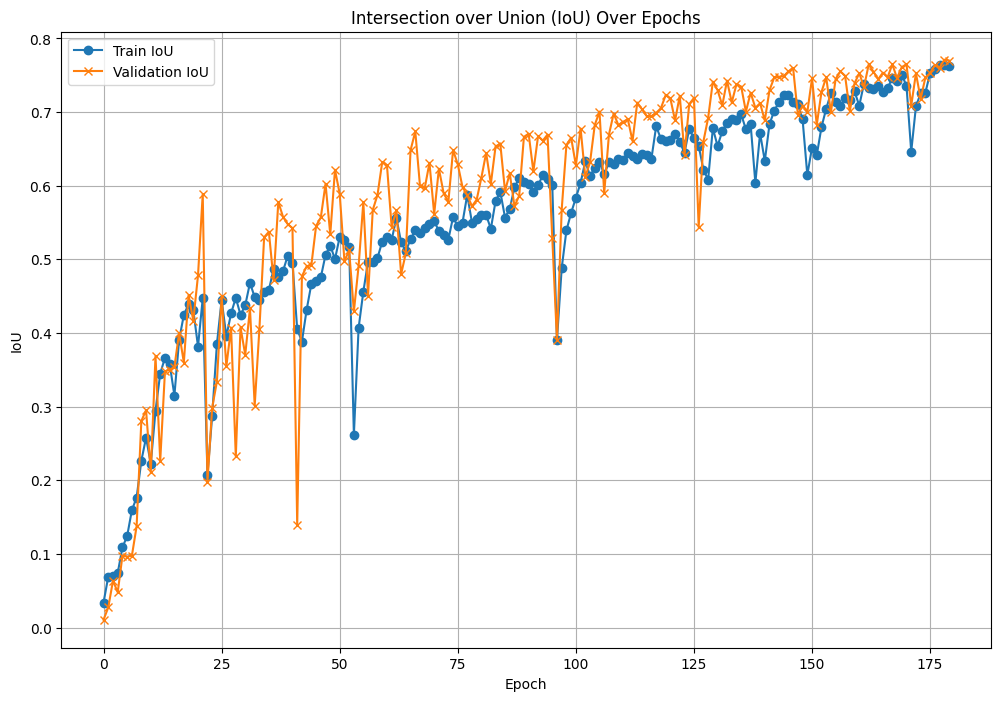

In [ ]:
# Trích xuất số liệu IoU từ lịch sử
train_iou = history.history['iou']
val_iou = history.history['val_iou']

# Vẽ đồ thị IoU
plt.figure(figsize=(18, 8))
plt.plot(train_iou, label='Train IoU', marker='o')
plt.plot(val_iou, label='Validation IoU', marker='x')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Intersection over Union (IoU) Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

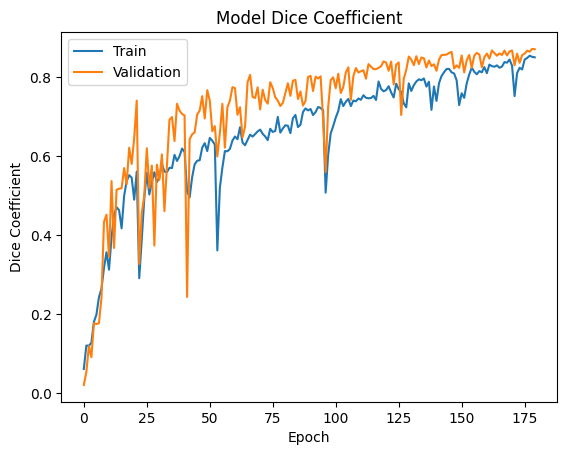

In [ ]:
# Vẽ đồ thị Dice coefficient
plt.figure(figsize=(18, 8))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

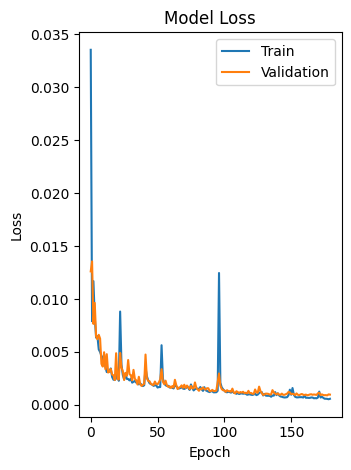

In [ ]:
# Loss
plt.figure(figsize=(18, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Lưu mô hình sau khi huấn luyện
model.save('/content/drive/MyDrive/best_04-08-2024.keras')

print("Model saved successfully!")

Model saved successfully!
